# Image Classification
In this project, we'll classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The dataset consists of airplanes, dogs, cats, and other objects. We'll preprocess the images, then train a convolutional neural network on all the samples. The images need to be normalized and the labels need to be one-hot encoded.  We'll get to apply and build a convolutional, max pooling, dropout, and fully connected layers.  At the end, we'll get to see your neural network's predictions on the sample images.
## Get the Data
Download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

CIFAR-10 Dataset: 171MB [01:05, 2.59MB/s]                              


All files found!


## Explore the Data
The dataset is broken into batches to prevent the machine from running out of memory.  The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

Understanding a dataset is part of making predictions on the data.  Let us play around with the code cell below by changing the `batch_id` and `sample_id`. The `batch_id` is the id for a batch (1-5). The `sample_id` is the id for a image and label pair in the batch.


Stats of batch 2:
Samples: 10000
Label Counts: {0: 984, 1: 1007, 2: 1010, 3: 995, 4: 1010, 5: 988, 6: 1008, 7: 1026, 8: 987, 9: 985}
First 20 Labels: [1, 6, 6, 8, 8, 3, 4, 6, 0, 6, 0, 3, 6, 6, 5, 4, 8, 3, 2, 6]

Example of Image 0:
Image - Min Value: 5 Max Value: 225
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


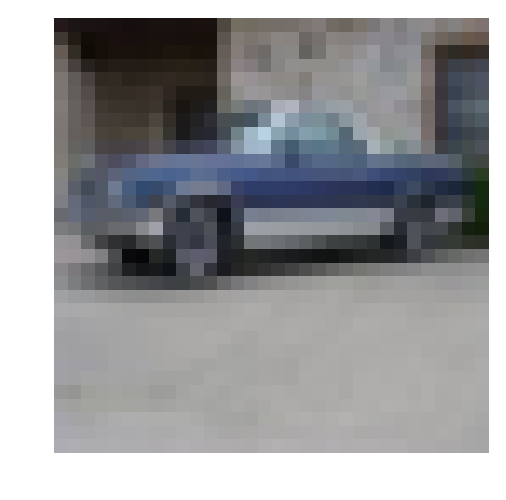

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 2
sample_id = 0
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Implement Preprocess Functions
### Normalize
The `normalize` function takes in image data, `x`, and returns it as a normalized Numpy array. The values will be in the range of 0 to 1, inclusive.  The return object should be the same shape as `x`.

In [3]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    x_copy = x/255
    return x_copy


tests.test_normalize(normalize)

Tests Passed


### One-hot encode
The `one_hot_encode` function. The input, `x`, are a list of labels.  The function returns the list of labels as One-Hot encoded Numpy array.  The possible values for labels are 0 to 9. The one-hot encoding function should return the same encoding for each value between each call to `one_hot_encode`.

In [4]:
from sklearn.preprocessing import LabelBinarizer
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    labels = np.array(np.eye(10)[x])
    lb = LabelBinarizer()
    ohe = lb.fit_transform(labels)
    return ohe


tests.test_one_hot_encode(one_hot_encode)

Tests Passed


### Randomize Data
As we saw from exploring the data above, the order of the samples are randomized.  It doesn't hurt to randomize it again, but we don't need to for this dataset.

## Preprocess all the data and save it
Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation.

In [5]:
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# Check Point
This is your first checkpoint.  If you ever decide to come back to this notebook or have to restart the notebook, you can start from here.  The preprocessed data has been saved to disk.

In [6]:
import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build the network
For the neural network, we'll build each layer into a function.

>[TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages to build each layer, except the layers you build in the "Convolutional and Max Pooling Layer" section.  TF Layers is similar to Keras's and TFLearn's abstraction to layers, so it's easy to pickup.

>Instead of using the TF Layers version of the `conv2d` class, [tf.layers.conv2d](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d), you would want to use the TF Neural Network version of `conv2d`, [tf.nn.conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d). 


### Input
The neural network needs to read the image data, one-hot encoded labels, and dropout keep probability. 
* `neural_net_image_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `image_shape` with batch size set to `None`.
 * Name the TensorFlow placeholder "x" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* `neural_net_label_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `n_classes` with batch size set to `None`.
 * Name the TensorFlow placeholder "y" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* `neural_net_keep_prob_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder) for dropout keep probability.
 * Name the TensorFlow placeholder "keep_prob" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).

These names will be used at the end to load the saved model.

Note: `None` for shapes in TensorFlow allow for a dynamic size.

In [7]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a bach of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    # TODO: Implement Function
    return tf.placeholder(tf.float32, shape=[None, *image_shape], name='x')


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    # TODO: Implement Function
    return tf.placeholder(tf.float32, shape=[None, n_classes], name='y')


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    # TODO: Implement Function
    return tf.placeholder(tf.float32, name='keep_prob')


tf.reset_default_graph()
tests.test_nn_image_inputs(neural_net_image_input)
tests.test_nn_label_inputs(neural_net_label_input)
tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


### Convolution and Max Pooling Layer
Convolution layers have a lot of success with images. For this code cell, we'll implement the function `conv2d_maxpool` to apply convolution then max pooling:
* Create the weight and bias using `conv_ksize`, `conv_num_outputs` and the shape of `x_tensor`.
* Apply a convolution to `x_tensor` using weight and `conv_strides`.
* Add bias
* Add a nonlinear activation to the convolution.
* Apply Max Pooling using `pool_ksize` and `pool_strides`.

In [8]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    conv1_w = tf.Variable(tf.truncated_normal((conv_ksize[0], conv_ksize[1], x_tensor.get_shape().as_list()[-1], conv_num_outputs),mean=0.0, stddev=0.05, dtype=tf.float32, seed=1234, name=None))
    conv1_bias = tf.Variable(tf.zeros(conv_num_outputs))
    
    conv1 = tf.nn.conv2d(x_tensor, conv1_w, strides=[1, conv_strides[0], conv_strides[1], 1], padding='SAME')
    conv1 = tf.nn.bias_add(conv1, conv1_bias)
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.max_pool(conv1, strides=[1,pool_strides[0],pool_strides[1],1], ksize=[1,pool_ksize[0],pool_ksize[1],1],
                          padding='SAME')
    
    return conv1


tests.test_con_pool(conv2d_maxpool)

Tests Passed


### Flatten Layer
The `flatten` function to change the dimension of `x_tensor` from a 4-D tensor to a 2-D tensor.  The output should be the shape (*Batch Size*, *Flattened Image Size*). We can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer.

In [9]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    return tf.contrib.layers.flatten(x_tensor)


tests.test_flatten(flatten)

Tests Passed


### Fully-Connected Layer
The `fully_conn` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*). We can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer.

In [12]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    weigths = tf.Variable(tf.truncated_normal((x_tensor.get_shape().as_list()[1], num_outputs),stddev=0.05))
    biases = tf.Variable(tf.zeros(num_outputs))
    x_tensor = tf.add(tf.matmul(x_tensor, weigths), biases)
    x_tensor = tf.nn.relu(x_tensor)
    return x_tensor


tests.test_fully_conn(fully_conn)

Tests Passed


### Output Layer
The `output` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*).

In [13]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    weigths = tf.Variable(tf.truncated_normal((x_tensor.get_shape().as_list()[1], num_outputs),stddev=0.05))
    biases = tf.Variable(tf.zeros(num_outputs))
    x_tensor = tf.add(tf.matmul(x_tensor, weigths), biases)
    return x_tensor


tests.test_output(output)

Tests Passed


### Create Convolutional Model
The function `conv_net` to create a convolutional neural network model. The function takes in a batch of images, `x`, and outputs logits.
* Apply 1, 2, or 3 Convolution and Max Pool layers
* Apply a Flatten Layer
* Apply 1, 2, or 3 Fully Connected Layers
* Apply an Output Layer
* Return the output
* Apply [TensorFlow's Dropout](https://www.tensorflow.org/api_docs/python/tf/nn/dropout) to one or more layers in the model using `keep_prob`.

In [14]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    # TODO: Apply 1, 2, or 3 Convolution and Max Pool layers
    #    Play around with different number of outputs, kernel size and stride
    # Function Definition from Above:
    #    conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    conv_ksize = (3,3)
    conv_strides = (1,1)
    pool_ksize = (2,2)
    pool_strides = (2,2)
    
    conv1_out = 24
    conv1 = conv2d_maxpool(x, conv1_out, conv_ksize, conv_strides, pool_ksize, pool_strides)

    conv2_out = 72
    conv2 = conv2d_maxpool(conv1, conv2_out, conv_ksize, conv_strides, pool_ksize, pool_strides)
    
    conv3_out = 144
    conv3 = conv2d_maxpool(conv2, conv3_out, conv_ksize, conv_strides, pool_ksize, pool_strides)

    # TODO: Apply a Flatten Layer
    # Function Definition from Above:
    #   flatten(x_tensor)
    layer_flatten = flatten(conv3)

    # TODO: Apply 1, 2, or 3 Fully Connected Layers
    #    Play around with different number of outputs
    # Function Definition from Above:
    #   fully_conn(x_tensor, num_outputs)
    num_outputs = 512
    fc1 = fully_conn(layer_flatten, num_outputs)
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    num_outputs = 256
    fc2 = fully_conn(fc1, num_outputs)
    fc2 = tf.nn.dropout(fc2, keep_prob)
    
    num_outputs = 128
    fc2 = fully_conn(fc1, num_outputs)
    fc2 = tf.nn.dropout(fc2, keep_prob)
    
    # TODO: Apply an Output Layer
    #    Set this to the number of classes
    # Function Definition from Above:
    #   output(x_tensor, num_outputs)
    final_out = output(fc2, 10)    
    # TODO: return output
    return final_out



##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tests.test_conv_net(conv_net)

Neural Network Built!


## Train the Neural Network
### Single Optimization
The function `train_neural_network` to do a single optimization.  The optimization uses `optimizer` to optimize in `session` with a `feed_dict` of the following:
* `x` for image input
* `y` for labels
* `keep_prob` for keep probability for dropout

This function will be called for each batch, so `tf.global_variables_initializer()` has already been called.

Note: Nothing needs to be returned. This function is only optimizing the neural network.

In [15]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    session.run(optimizer, feed_dict={x: feature_batch, y: label_batch, keep_prob: keep_probability})


tests.test_train_nn(train_neural_network)

Tests Passed


### Show Stats
The function `print_stats` to print loss and validation accuracy.  Use the global variables `valid_features` and `valid_labels` to calculate validation accuracy.  Use a keep probability of `1.0` to calculate the loss and validation accuracy.

In [16]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    loss = session.run(cost, feed_dict={x: feature_batch, y: label_batch, keep_prob: 1.})
    
    valid_acc = session.run(accuracy, feed_dict={x: valid_features, y: valid_labels, keep_prob: 1.})

    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss,valid_acc))

### Hyperparameters
Tune the following parameters:
* Set `epochs` to the number of iterations until the network stops learning or start overfitting
* Set `batch_size` to the highest number that your machine has memory for.  Most people set them to common sizes of memory:
 * 64
 * 128
 * 256
 * ...
* Set `keep_probability` to the probability of keeping a node using dropout

In [20]:
# Tune Parameters
epochs = 25
batch_size = 256
keep_probability = 0.5

### Train on a Single CIFAR-10 Batch
Instead of training the neural network on all the CIFAR-10 batches of data, let's use a single batch. This should save time while we iterate on the model to get a better accuracy.  Once the final validation accuracy is 50% or greater, run the model on all the data.

In [21]:
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.1982 Validation Accuracy: 0.227800
Epoch  2, CIFAR-10 Batch 1:  Loss:     2.1451 Validation Accuracy: 0.297000
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.9787 Validation Accuracy: 0.374600
Epoch  4, CIFAR-10 Batch 1:  Loss:     1.7235 Validation Accuracy: 0.415800
Epoch  5, CIFAR-10 Batch 1:  Loss:     1.5614 Validation Accuracy: 0.430200
Epoch  6, CIFAR-10 Batch 1:  Loss:     1.4580 Validation Accuracy: 0.456600
Epoch  7, CIFAR-10 Batch 1:  Loss:     1.2816 Validation Accuracy: 0.477800
Epoch  8, CIFAR-10 Batch 1:  Loss:     1.1460 Validation Accuracy: 0.492400
Epoch  9, CIFAR-10 Batch 1:  Loss:     1.0984 Validation Accuracy: 0.493000
Epoch 10, CIFAR-10 Batch 1:  Loss:     0.9037 Validation Accuracy: 0.528400
Epoch 11, CIFAR-10 Batch 1:  Loss:     0.8285 Validation Accuracy: 0.512800
Epoch 12, CIFAR-10 Batch 1:  Loss:     0.7358 Validation Accuracy: 0.530200
Epoch 13, CIFAR-10 Batch 1:  Loss:     0.6729

### Fully Train the Model
Now that we got a good accuracy with a single CIFAR-10 batch, try it with all five batches.

In [22]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.1959 Validation Accuracy: 0.255000
Epoch  1, CIFAR-10 Batch 2:  Loss:     1.8818 Validation Accuracy: 0.332000
Epoch  1, CIFAR-10 Batch 3:  Loss:     1.6236 Validation Accuracy: 0.382600
Epoch  1, CIFAR-10 Batch 4:  Loss:     1.5960 Validation Accuracy: 0.402400
Epoch  1, CIFAR-10 Batch 5:  Loss:     1.5434 Validation Accuracy: 0.438200
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.6538 Validation Accuracy: 0.465200
Epoch  2, CIFAR-10 Batch 2:  Loss:     1.4478 Validation Accuracy: 0.470400
Epoch  2, CIFAR-10 Batch 3:  Loss:     1.1861 Validation Accuracy: 0.458000
Epoch  2, CIFAR-10 Batch 4:  Loss:     1.2515 Validation Accuracy: 0.493800
Epoch  2, CIFAR-10 Batch 5:  Loss:     1.3236 Validation Accuracy: 0.517400
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.3023 Validation Accuracy: 0.536400
Epoch  3, CIFAR-10 Batch 2:  Loss:     1.1121 Validation Accuracy: 0.535800
Epoch  3, CIFAR-10 Batch 3:  Loss:     0.9743 Validation Accuracy: 0.550400


# Checkpoint
The model has been saved to disk.
## Test Model
Test the model against the test dataset.  This will be our final accuracy.

Testing Accuracy: 0.72216796875



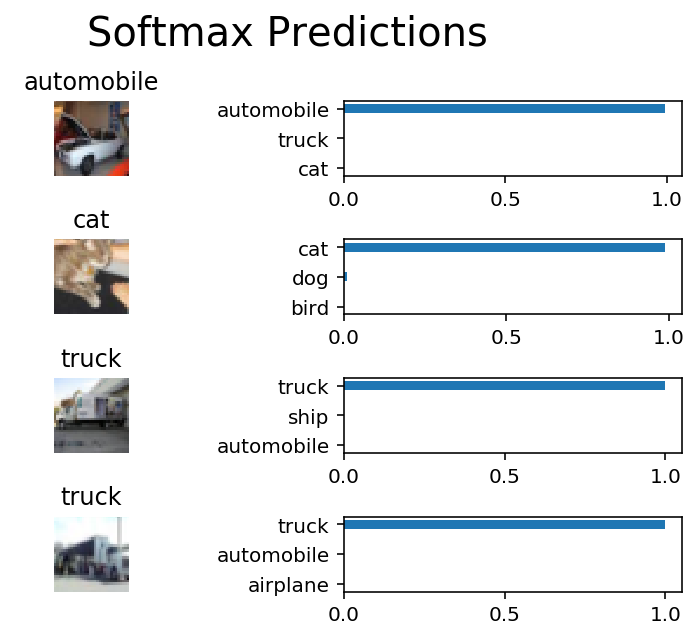

In [23]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()

## Why 50-70% Accuracy?
You might be wondering why we can't get an accuracy any higher. First things first, 50% isn't bad for a simple CNN.  Pure guessing would get you 10% accuracy. However, you might notice people are getting scores [well above 70%](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130).  That's because we haven't tweaked a lot of the knobs in the equation. We will do it later. This was mostly to get the feet wet with the CNN.